In [3]:
#Data Science Libraries
import pandas as pd 
import numpy as np
#Sklearn 
# for split arrays into training and test
# Hyperparamater tuning w/ random search strategy
from sklearn.model_selection import train_test_split, RandomizedSearchCV
#Scales by removing mean and scaling to unit variance
# Encodes categorical int features as one-hot numeric array
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer #To transform cols
from sklearn.pipeline import Pipeline #Chain transformers and estimators
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error #Error Metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor #Ensemble Models
from sklearn.linear_model import LinearRegression #inear Regression Model
from sklearn.tree import DecisionTreeRegressor #Decision Trees
from sklearn.svm import SVR 
#Visualization library
import matplotlib.pyplot as plt

In [4]:
#Read file with pandas
edmonton_file_path = 'edmonton_housing_data_Feb15_2022.csv'
edmonton_data = pd.read_csv(edmonton_file_path)
edmonton_data.columns

Index(['House Description', 'Price', 'Bedrooms', 'Bathrooms', 'Full Baths',
       'Square Footage', 'Acres', 'Year Built', 'Type', 'Sub-Type', 'Style',
       'Address', 'Area', 'Community', 'Condo', 'City', 'County', 'Province',
       'Postal Code', 'Features', 'Parking Spaces', 'Parking', 'Is Waterfront',
       'Has Pool', 'Interior', 'Interior Features', 'Heating', 'Fireplace',
       '# of Stories', 'Has Basement', 'Basement', 'Separate Entrance',
       'Exterior', 'Exterior Features', 'Construction', 'Foundation',
       'Elementary', 'Middle', 'High', 'Foreclosure', 'RE / Bank Owned',
       'Office', 'Bedrooms Above Grade', '# of Garages', 'Garages',
       'Half Baths', 'Fireplaces', 'Zoning', 'Lot Description', 'HOA Fees',
       'HOA Fees Freq.', 'Condo Fee'],
      dtype='object')

In [5]:
edmonton_data.head()

,House Description,Price,Bedrooms,Bathrooms,Full Baths,Square Footage,Acres,Year Built,Type,Sub-Type,...,Bedrooms Above Grade,# of Garages,Garages,Half Baths,Fireplaces,Zoning,Lot Description,HOA Fees,HOA Fees Freq.,Condo Fee
0,"Rare property on the market, house converted t...","$399,990",1,1.0,1.0,787,0.12,1948,Single Family,Residential Detached Single Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,This fantastic family home has an option to As...,"$357,000",4,2.0,2.0,929,0.15,1954,Single Family,Residential Detached Single Family,...,2.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"At over 1150 square feet, this Allendale 3+2 b...","$499,600",5,2.0,2.0,"1,161",0.14,1959,Single Family,Residential Detached Single Family,...,3.0,1,7.32x4.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gorgeous upgrades and a lower level suite in C...,"$398,800",4,3.0,3.0,"1,217",0.15,1976,Single Family,Residential Detached Single Family,...,3.0,2,24x26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AMAZING VALUE! Welcome home to this well-maint...,"$279,900",3,2.0,1.0,"1,160",0.00,1979,Single Family,Residential Detached Single Family,...,3.0,2,NaN,1.0,"Gas, Oak Surround",NaN,NaN,NaN,NaN,NaN


In [6]:
#Data Cleaning
#Convert remove $ or , (regular expression) and convert prices to float
edmonton_data['Price'] = edmonton_data['Price'].replace('[$,]', '', regex=True).astype(float) #Will be y
#Clean numerical cols (features)
edmonton_data['Square Footage'] = edmonton_data['Square Footage'].replace(',', '', regex=True).astype(float)
edmonton_data['Acres'] = pd.to_numeric(edmonton_data['Acres'], errors='coerce') #coerce to NaN

In [7]:
#Convert "bool" fireplace to int values
edmonton_data['Has_Fireplace'] = edmonton_data['Fireplaces'].notna().astype(int) #bool mask (True if exist)

In [8]:
#Relevant Features List (X)
features = ['Bedrooms', 'Bathrooms', 'Square Footage', 'Acres', 'Year Built', 'Type', 'Community', '# of Stories', 'Has_Fireplace']
X = edmonton_data[features]
#Target = Price (y)
target = 'Price'
#Drop missing values and assign to dataframe
df = edmonton_data[features + [target]].dropna() #Remove NaN

In [9]:
#Preprocessing
numerical_features = ['Bedrooms', 'Bathrooms', 'Square Footage', 'Acres', 'Year Built', '# of Stories', 'Has_Fireplace'] #num
categorical_features = ['Type', 'Community'] #string
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]) #Ignore instead of raising error

In [10]:
#Split Data
X = df.drop(columns=[target]) #Drop target to get X
y = df[target] #Get target for y
#80% training and 20% test subsets.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) 

In [11]:
#Init Models - random_state=#cols
models = { 
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVM': SVR()
}

In [12]:
#Train & Eval Models
#Results Dict
results = {}
#Iterate over name: model in models dict
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), #col transformer (scaling and hot-encoding)
        ('regressor', model) #regressor model from models dict
    ])
    pipeline.fit(X_train, y_train) #Train pipeline on training data.
    y_pred = pipeline.predict(X_test) #Use trained pl to predict on test data

    #Get Metrics
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred)) #Root Mean Square Error 
    R2 = r2_score(y_test, y_pred) #R^2 Variance
    MAE = mean_absolute_error(y_test, y_pred) #Mean Absolute Error
    RMAE = (MAE / y_train.mean()) * 100 #Relative Mean Absolute Error

    #Set Results
    results[name] = {
        'RMSE': RMSE,
        'R^2 Score': R2,
        'MAE': MAE,
        'RMAE': RMAE
    }

In [13]:
#Compare Results
results_df = pd.DataFrame(results).T #dict of dicts -> df (transpose)
print("Model Comparison:")
print(results_df.sort_values(by='RMSE'))

Model Comparison:
                            RMSE  R^2 Score            MAE       RMAE
Gradient Boosting  153047.443311   0.770625   88587.134828  20.652984
Linear Regression  155805.751991   0.762282  100273.298620  23.377467
Random Forest      164896.335327   0.733734   87760.064507  20.460162
Decision Tree      192008.909146   0.638975  105093.789706  24.501304
SVM                331760.108205  -0.077812  207094.282904  48.281444


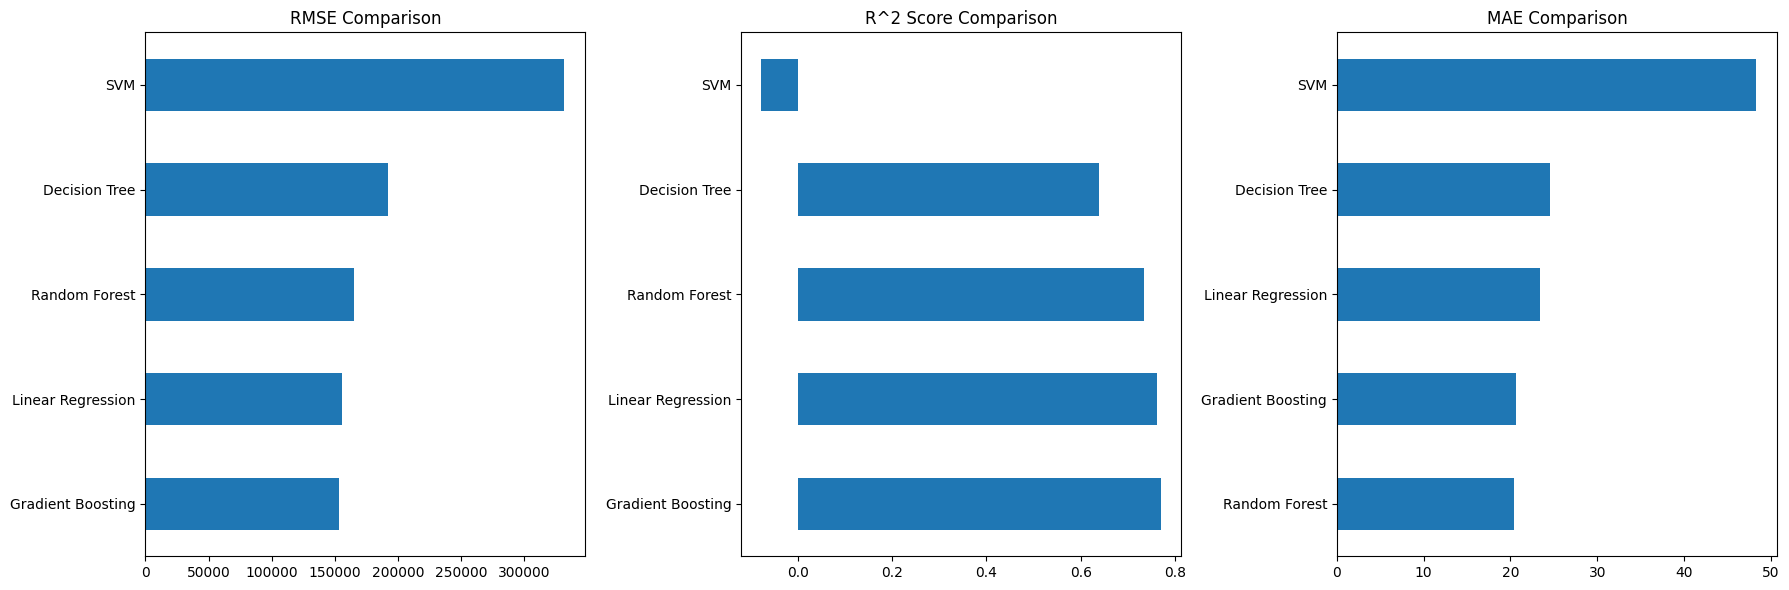

In [14]:
#Visualization w/ Matplotlib (plt)
#Width & Height of Figure - figsize=(width, height)
plt.figure(figsize=(18,6))
#Subplots - (nrows, ncols, index) - kind = 'barh' meaning horizontal bars
#RMSE Subplot
plt.subplot(1,3,1)
results_df['RMSE'].sort_values().plot(kind='barh', title='RMSE Comparison')
#R^2 Score Subplot
plt.subplot(1,3,2)
results_df['R^2 Score'].sort_values(ascending=False).plot(kind='barh', title='R^2 Score Comparison') #Reverse Order 
#RMAE Subplot
plt.subplot(1,3,3)
results_df['RMAE'].sort_values().plot(kind='barh', title='MAE Comparison')
plt.tight_layout() #Neater Layout
plt.show()

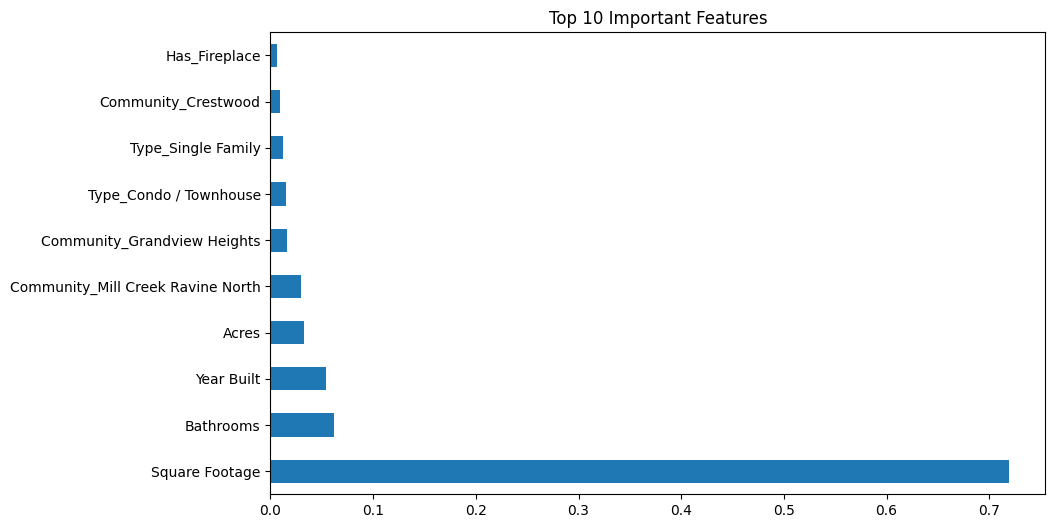

In [15]:
#Feature Importance for Best Model
best_model = results_df['RMSE'].idxmin() #Get min error model according to RMSE metric
if hasattr(models[best_model], 'feature_importances_'):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', models[best_model])
    ])
    pipeline.fit(X_train, y_train)

    #Get Feature Names After One-Hot Encoding
    cat_encoder = preprocessor.named_transformers_['cat']
    cat_features = cat_encoder.get_feature_names_out(categorical_features)
    all_features = numerical_features + list(cat_features)

    #Set Importances
    importances = pipeline.named_steps['regressor'].feature_importances_
    feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)[:10]

    #Visualize
    plt.figure(figsize=(10,6))
    feat_imp.plot(kind='barh', title='Top 10 Important Features')
    plt.show()